# Adversarial Robustness of Neural Networks 
# (Note: Just an Implementation notebook not a full trained high accurate model)

## Task 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import timm
import art
import torch
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod
from art.defences.detector.evasion import BinaryInputDetector
from art.defences.trainer import AdversarialTrainer

In [2]:
import os

model_weights_path = os.listdir(os.path.join(os.getcwd(),'files'))

In [3]:
timm.is_model_pretrained('resnet34')

True

## Task 2: Load the Pretrained Model

In [4]:
resnet_34 = timm.create_model('resnet34',pretrained=True)

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [5]:
resnet_34.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [6]:
custom_model_weights = torch.load('/files/pytorch_model_resnet34.bin')

In [7]:
resnet_34.conv1 = torch.nn.Conv2d(3,64,kernel_size=(3,3),padding=(1,1),stride=(1,1),bias=False)

In [8]:
resnet_34.fc.weight = torch.nn.Parameter(custom_model_weights['fc.weight'])

In [9]:
resnet_34.fc.bias = torch.nn.Parameter(custom_model_weights['fc.bias'])

In [10]:
resnet_34.load_state_dict(torch.load('/files/pytorch_model_resnet34.bin'))

<All keys matched successfully>

## Task 3: Load the Dataset

In [11]:
#Load the Transformations pipeline
from torchvision.transforms import v2

train_transformations = v2.Compose([
    v2.RandomCrop(size=(512,512)),
    v2.RandomHorizontalFlip(),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transformations = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [12]:
import torchvision.datasets
from sklearn.model_selection import train_test_split

train_data = torchvision.datasets.CIFAR10(os.getcwd(),download=True,transform=train_transformations)
test_data = torchvision.datasets.CIFAR10(os.getcwd(),download=True,train=False,transform=test_transformations)

100%|██████████| 170498071/170498071 [00:01<00:00, 91945404.86it/s] 


Extracting /cifar-10-python.tar.gz to /
Files already downloaded and verified


## Task 4: Perform Adversarial Attacks

In [14]:
resnet_34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [15]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_34.parameters())

art_model = PyTorchClassifier(
    input_shape=(3,32,32),
    model= resnet_34,
    loss= loss,
    optimizer=optimizer,
    nb_classes=10
)

In [16]:
#Scaling Train images
scaled_train = (train_data.data.transpose(0, 3, 1, 2)[0:1000]/255)
scaled_train_targets =  np.array(train_data.targets)

In [17]:
#Scaling Test Images
scaled_test = test_data.data.transpose(0, 3, 1, 2)[0:1000]/255
scaled_test_targets = np.array(test_data.targets)

In [18]:
#performing adversal attacks
adversal_func = FastGradientMethod(art_model,norm=1)
train_attack = adversal_func.generate(scaled_train,scaled_train_targets)

In [19]:
test_attack = adversal_func.generate(scaled_test,scaled_test_targets)

## Task 5: Visualize Adversarial Images

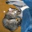

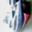

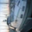

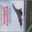

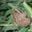

In [20]:
import PIL
from IPython.display import display

for image in scaled_test[0:5]:
    pil_image = PIL.Image.fromarray((image.transpose()* 255).astype(np.uint8))
    display(pil_image)

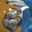

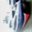

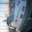

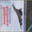

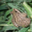

In [21]:
for image in test_attack[0:5]:
    pil_image = PIL.Image.fromarray((image.transpose()* 255).astype(np.uint8))
    display(pil_image)

## Task 6: Evaluate Model Performance on Adversarial Images

In [22]:
predictions = []
from tqdm import tqdm
for image in tqdm(test_attack,total=len(test_attack)):
    model_predict = art_model.predict(torch.from_numpy(image).unsqueeze(dim=0))
    predictions.append(np.argmax(model_predict))

100%|██████████| 1000/1000 [00:28<00:00, 35.23it/s]


In [23]:
print(((np.sum(predictions==scaled_test_targets))/len(scaled_test_targets)))

0.0


/tmp/ipykernel_204/1255212014.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(((np.sum(predictions==scaled_test_targets))/len(scaled_test_targets)))


## Task 7: Evaluate Model Performance on Normal Images

In [24]:
predictions = []
from tqdm import tqdm
for image in tqdm(scaled_test.astype(np.float32),total=len(scaled_test)):
    model_predict = art_model.predict(torch.from_numpy(image).unsqueeze(dim=0))
    predictions.append(np.argmax(model_predict))

100%|██████████| 1000/1000 [00:28<00:00, 35.26it/s]


In [25]:
print(((np.sum(predictions==scaled_test_targets))/len(scaled_test_targets)))

0.0


/tmp/ipykernel_204/1255212014.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(((np.sum(predictions==scaled_test_targets))/len(scaled_test_targets)))


## Task 8: Train a Classifier to Detect Adversarial Examples

In [26]:
#Classifier

#Load the model
res_18 = timm.create_model('resnet18',pretrained=True)

#Modify the weights
custom_weights_res_18 = torch.load('/files/pytorch_model_resnet18.bin')
res_18.conv1.weight = torch.nn.Parameter(custom_weights_res_18['conv1.weight'])
res_18.fc.weight = torch.nn.Parameter(custom_weights_res_18['fc.weight'])
res_18.fc.bias = torch.nn.Parameter(custom_weights_res_18['fc.bias'])

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [27]:
res_18.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)

art_classifier = PyTorchClassifier(
    input_shape=(3,64),
    model = res_18,
    loss = loss,
    optimizer = optimizer,
    nb_classes = 2,
)

In [28]:
#modify data to have labels for adversial or clean
train_data.targets = [1 for _ in range(len(train_data.data))]

In [29]:
train_attack = adversal_func.generate(scaled_train,np.array([2 for _  in range(len(scaled_train))]))

In [30]:
final_dataset = torch.utils.data.ConcatDataset([train_data,train_attack])

In [31]:
np.array(train_data.data).shape

(50000, 32, 32, 3)

In [32]:
train_attack.shape

(1000, 3, 32, 32)

In [ ]:
train_data.data[0:1000].transpose(0,3,1,2)

In [34]:
x_train = np.concatenate((train_attack,train_data.data[0:1000].transpose(0,3,1,2)))

In [35]:
train_data_targets = [[1,0] for _ in range(len(train_data.data[0:1000]))]
train_attack_targets = [[0,1] for _ in range(len(train_data.data[0:1000]))]

y_train = np.concatenate((np.array(train_attack_targets),np.array(train_data_targets))).astype(np.float32)

In [36]:
binary_art = BinaryInputDetector(art_classifier)
binary_art.fit(x_train,y_train)

In [37]:
#Pre_trained model
binary_art.detector.model.load_state_dict(torch.load('/files/adv_detector_fgsm.bin'))

<All keys matched successfully>

## Task 9: Identify Adversarial Examples From Normal Examples

In [ ]:
#Normal dataset
binary_art.detect(np.array(scaled_test).astype(np.float32))

In [ ]:
#Adversal Images
binary_art.detect(np.array(test_attack).astype(np.float32))

## Task 10: Train the Model With Adversarial Examples

In [40]:
#Lets create a proper full data based classfier

base_model = timm.create_model('resnet18',pretrained=True)

#loading custom pretrained weights
custom_weights_base_model = torch.load('/files/pytorch_model_resnet34.bin')

base_model.conv1.weight = torch.nn.Parameter(custom_weights_base_model['conv1.weight'])
base_model.fc.weight = torch.nn.Parameter(custom_weights_base_model['fc.weight'])
base_model.fc.weight = torch.nn.Parameter(custom_weights_base_model['fc.bias'])

base_model.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)

base_model = PyTorchClassifier(
    input_shape=(3,32,32),
    model= base_model,
    loss= loss,
    optimizer=optimizer,
    nb_classes=2
)

robust_classfier = AdversarialTrainer(base_model,[adversal_func])
robust_classfier.fit(x_train,y_train)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

## Task 11: Evaluate Model's Performance After Adversarial Training

In [41]:
test_acc = np.sum(np.argmax(robust_classfier.predict(scaled_test.astype(np.float32)),axis=1)==scaled_test_targets)

/tmp/ipykernel_204/683413276.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  test_acc = np.sum(np.argmax(robust_classfier.predict(scaled_test.astype(np.float32)),axis=1)==scaled_test_targets)


In [42]:
(test_acc/len(test_attack))*100

0.0